In [2]:
import os
os.chdir("D:/DataScienceProjects/DATS6501_CapstoneProject/DATS6501_GWU_CAP")

import networkx as nx
import numpy as np
import pandas as pd
import time
import datetime
from random import randint
#import math
#import random
#from osgeo import osr, ogr
from sklearn import preprocessing, neural_network, tree, ensemble, neighbors, model_selection, metrics
from collections import defaultdict
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
#import pickle
import cPickle as pickle
import zipfile
from sklearn.feature_selection import SelectFromModel, mutual_info_regression, mutual_info_classif, RFECV, RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC, LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GridSearchCV
from pyproj import Proj, transform

import utility_functions

PyTables is not installed. No support for HDF output.


## Build crash model
### Part I Variable preprocessing

First, crash reports need to be processed and ingeste.
Here only crash IDs were used to join to the road segment.
Preprocessing includes:
1) calculate any latitude and longitude pairs where coordinates are available; 
2) remove any crash records without latitude and longitude pairs

In [3]:
#read in: 'CrashID','TSCrashCoordinateX','TSCrashCoordinateY','TSCrashLatitude','TSCrashLongitude', 'TotalFatals', 'TotalInjured',
#'DayofWeek', 'CrashHour', 'CrashSeverityCd' will be needed when running prediction
rawcrash2015 = pd.read_csv('./rawInput/CRASH2015.csv', usecols=[1, 44, 45, 46, 47, 13, 14])#7, 8, 67
rawcrash2016 = pd.read_csv('./rawInput/CRASH2016.csv', usecols=[1, 44, 45, 46, 47, 13, 14])

crash2015 = utility_functions.crash_preprocessing(rawcrash2015)
crash2016 = utility_functions.crash_preprocessing(rawcrash2016)

crash2015.rename(index=str, columns={"TSCrashLatitude": "Latitude", "TSCrashLongitude":"Longitude"}, inplace=True)
crash2016.rename(index=str, columns={"TSCrashLatitude": "Latitude", "TSCrashLongitude":"Longitude"}, inplace=True)
crash2015.drop(['TSCrashCoordinateX','TSCrashCoordinateY'],axis=1,inplace=True)
crash2016.drop(['TSCrashCoordinateX','TSCrashCoordinateY'],axis=1,inplace=True)

Imputed 32518 lat, lon pairs
820 records were removed.
Imputed 44702 lat, lon pairs
0 records were removed.


C:\Users\isaac\AppData\Local\conda\conda\envs\py27\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\isaac\AppData\Local\conda\conda\envs\py27\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Next, the 311 requests are ingested and screened for bad records, as well as for false requests (i.e. service requsts submitted but not located).

In [4]:
#311 Potholes requests
Potholes = pd.read_csv('./rawInput/311_Service_Requests_Pot_Holes_Reported.csv', usecols=[0,3,6,16,17])

exclude1 = ' No Problem Found'
exclude2 = 'No Potholes Found'
exclude3 = 'No Problem Found'
exclude4 = 'No Such Address Found'

Potholes = Potholes[(Potholes['MOST RECENT ACTION'] != exclude1) & (Potholes ['MOST RECENT ACTION'] != exclude2) & (Potholes ['MOST RECENT ACTION'] != exclude3)
                    & (Potholes['MOST RECENT ACTION'] != exclude4)]
Potholes.reset_index(drop=True, inplace=True)

utility_functions.extract_year(Potholes)

Potholes2015 = Potholes[Potholes['CREATION YEAR'] == 2015]
Potholes2016 = Potholes[Potholes['CREATION YEAR'] == 2016]
Potholes2015.rename(index=str, columns={"LATITUDE": "Latitude", "LONGITUDE":"Longitude"}, inplace=True)
Potholes2016.rename(index=str, columns={"LATITUDE": "Latitude", "LONGITUDE":"Longitude"}, inplace=True)

#Street light more than one out
StreetLight_all = pd.read_csv('./rawInput/311_Service_Requests_Street_Lights_All_Out.csv', usecols=[0,3,12,13])

utility_functions.extract_year(StreetLight_all)
StreetLight_all2015 = StreetLight_all[StreetLight_all['CREATION YEAR'] == 2015]
StreetLight_all2016 = StreetLight_all[StreetLight_all['CREATION YEAR'] == 2016]
StreetLight_all2015.reset_index(drop=True,inplace=True)
StreetLight_all2016.reset_index(drop=True,inplace=True)

#Street light one out
StreetLight_one = pd.read_csv('./rawInput/311_Service_Requests_Street_Lights_One_Out.csv', usecols=[0,3,12,13])

utility_functions.extract_year(StreetLight_one)
StreetLight_one2015 = StreetLight_one[StreetLight_one['CREATION YEAR'] == 2015]
StreetLight_one2016 = StreetLight_one[StreetLight_one['CREATION YEAR'] == 2016]
StreetLight_one2015.reset_index(drop=True,inplace=True)
StreetLight_one2016.reset_index(drop=True,inplace=True)

#Tree debris
Tree_debris = pd.read_csv('./rawInput/311_Service_Requests_Tree_Debris.csv', usecols=[0,3,15,16])

utility_functions.extract_year(Tree_debris)
Tree_debris2015 = Tree_debris[Tree_debris['CREATION YEAR'] == 2015]
Tree_debris2016 = Tree_debris[Tree_debris['CREATION YEAR'] == 2016]
Tree_debris2015.reset_index(drop=True,inplace=True)
Tree_debris2016.reset_index(drop=True,inplace=True)

#Tree trims
Tree_trims = pd.read_csv('./rawInput/311_Service_Requests_Tree_Trims.csv', usecols=[0,3,13,14])

utility_functions.extract_year(Tree_trims)
Tree_trims2015 = Tree_trims[Tree_trims['CREATION YEAR'] == 2015]
Tree_trims2016 = Tree_trims[Tree_trims['CREATION YEAR'] == 2016]
Tree_trims2015.reset_index(drop=True,inplace=True)
Tree_trims2016.reset_index(drop=True,inplace=True)

### Part II attach features to the road network and process into useful features

In [5]:
#crash datasets have more than one variable to be attached, and thus considered separately
col_crash = ['CrashID','TotalFatals', 'TotalInjured']#'DayOfWeekCode', 'CrashHour','CrashSeverityCd'
desig_name_crash = ['CrashID', 'TotalFatals', 'TotalInjured']#'DayofWeek', 'CrashHour', 'CrashSeverity'
#name of the dataset variable: crashID2015,crashID2016

datasets2015 = [Potholes2015, StreetLight_all2015, StreetLight_one2015, Tree_debris2015, Tree_trims2015]
datasets2016 = [Potholes2016, StreetLight_all2016, StreetLight_one2016, Tree_debris2016, Tree_trims2016]

#data columns to be attached to the road network and their designated name in the graph object
data = ['SERVICE REQUEST NUMBER', 'Service Request Number', 'Service Request Number', 'Service Request Number', 'Service Request Number']
desig_name = ['Potholes','StreetLightAll','StreetLightOne','TreeDeb','TreeTrim']

In [6]:
#load the road network graphs that are already filled with AADT from the previous model
G15 = pickle.load(open("./output/HwyAADT_filled2015.p", 'rb'))
G16 = pickle.load(open("./output/HwyAADT_filled2016.p", 'rb'))

In [7]:
#attach the crash record information to the road network
utility_functions.attach_crash(G15, crash2015, col_crash, desig_name_crash)
utility_functions.attach_crash(G16, crash2016, col_crash, desig_name_crash)

0.0440001487732 seconds to extract the lat/lons of all the road segments.


utility_functions.py:171: RuntimeWarning: invalid value encountered in divide
  (p2y - p1y) ** 2 + (p2x - p1x) ** 2)


196.637999773 seconds to attach 89576 records.
0.421999931335 seconds to extract the lat/lons of all the road segments.


utility_functions.py:176: RuntimeWarning: invalid value encountered in less_equal
  p1y_greater_than = abs(p1y) <= abs(y)  # p1y <= y
utility_functions.py:177: RuntimeWarning: invalid value encountered in less_equal
  p2y_less_than = abs(y) <= abs(p2y)  # y <= p2y


220.644999981 seconds to attach 97563 records.


In [8]:
#attach other data to the road network
utility_functions.attach_other(G15, datasets2015, data, desig_name)
utility_functions.attach_other(G16, datasets2015, data, desig_name)

0.0539999008179 seconds to extract the lat/lons of all the road segments.


utility_functions.py:174: RuntimeWarning: invalid value encountered in less_equal
  p1x_greater_than = abs(p1x) <= abs(x)  # p1x <= x
utility_functions.py:175: RuntimeWarning: invalid value encountered in less_equal
  p2x_less_than = abs(x) <= abs(p2x)  # x <= p2x


90.4719998837 seconds to attach 55895 records
31.3890001774 seconds to attach 18634 records
150.018000126 seconds to attach 90675 records
28.6840000153 seconds to attach 17070 records
66.8790001869 seconds to attach 39610 records
0.59500002861 seconds to extract the lat/lons of all the road segments.
95.4779999256 seconds to attach 55895 records
32.0550000668 seconds to attach 18634 records
155.914000034 seconds to attach 90675 records
29.5130000114 seconds to attach 17070 records
67.396999836 seconds to attach 39610 records


In [9]:
#create fields that counts the number of incidents
utility_functions.convert_to_count(G15, 'all_info_count2015.p')
utility_functions.convert_to_count(G16, 'all_info_count2016.p')

#because in 2015 version of road network information dataset, road class is named as "FUNC_CLASS" compared to "FC" in the 2016 version
#here rename the function class variable in 2015
G = nx.Graph()
G = pickle.load(open("./output/all_info_count2015.p", 'rb'))
for edge in G.edges_iter(data=True):
    data = edge[2]
    data['FC'] = data['FUNC_CLASS']
    del data['FUNC_CLASS']
pickle.dump(G, open("./output/all_info_count2015.p", 'wb'))
del G

12719
12896


In [10]:
#Road segments are encoded with a unique identifier
#Inventory number, BEG_STA, END_STA can uniquely identify a road segment, so we use the combination of these three values to generate an ID for each road segment
G15 = nx.Graph()
G16 = nx.Graph()
G15 = pickle.load(open("./output/all_info_count2015.p", 'rb'))
G16 = pickle.load(open("./output/all_info_count2016.p", 'rb'))
 
#create a unique ID number for each road segment 
utility_functions.seg_encoder(G15)
utility_functions.seg_encoder(G16)

pickle.dump(G15, open("./output/all_info_count2015.p", 'wb'))
pickle.dump(G16, open("./output/all_info_count2016.p", 'wb'))

### Part III Create training and testing sets

In [11]:
#load road network and crash information
G15 = pickle.load(open("./output/all_info_count2015.p", 'rb'))
G16 = pickle.load(open("./output/all_info_count2016.p", 'rb'))
roadnetworks = [G15, G16]

crash2016 = pd.read_csv("./rawInput/CRASH2016.csv", usecols=[1, 7, 8, 62])
crash2015 = pd.read_csv("./rawInput/CRASH2015.csv", usecols=[1, 7, 8, 62])
crashreports = [crash2015, crash2016]

#X_columns should be the common elements from all the raodnetworks
X2015 = pickle.load(open("./output/X_Pre2015.p", 'rb'))
X2016 = pickle.load(open("./output/X_Pre2016.p", 'rb'))

X_columns = [i for i in X2015 if i in X2016] + ['FC', 'AADT'] + ['Potholes','StreetLightAll','StreetLightOne','TreeDeb','TreeTrim']

Exporting to csv...
Done!
Total number of common road segments: 17401
30 th percentile is 1.0
The maximum number of crashes on a road segment for the time of interest is: 470
4889 road segments had no crashes for the time period of interest.


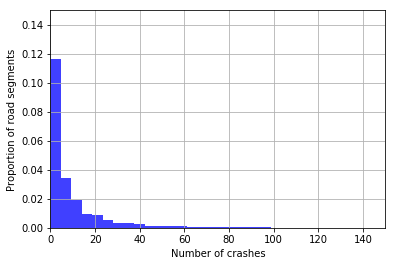

746 identical recoreds dropped.
Cloning info for road segments...
Elapsed time: 5.68600010872
Creating series for hours of the day, day of week and month of the year...
Exporting to csv...
Done!


In [12]:
utility_functions.get_crash_for_training(X_columns, roadnetworks, crashreports)

#crash counts is a dataframe with rows as the each road segment and column representing the number of crash events
crash_counts = utility_functions.get_crash_number_distribution(roadnetworks, 30, True)
utility_functions.get_nocrash_for_training(X_columns, roadnetworks, crash_counts, threshold=0)

### Part IV train the model

In [13]:
#load the samples
positive = pd.read_csv("AllCrashes.csv")
negative = pd.read_csv("NoCrashes.csv")

C:\Users\isaac\AppData\Local\conda\conda\envs\py27\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (12,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\isaac\AppData\Local\conda\conda\envs\py27\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (4,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
#some feature engineering is needed to preserve the cyclical nature of variables such as hour of the day and day of the week
positive['hr_sin'] = np.sin(positive.CrashHour*2*np.pi/24)
positive['hr_cos'] = np.cos(positive.CrashHour*2*np.pi/24)
positive['day_sin'] = np.sin((positive.DayOfWeekCode-1)*2*np.pi/7)
positive['day_cos'] = np.cos((positive.DayOfWeekCode-1)*2*np.pi/7)

negative['hr_sin'] = np.sin(negative.CrashHour*2*np.pi/24)
negative['hr_cos'] = np.cos(negative.CrashHour*2*np.pi/24)
negative['day_sin'] = np.sin((negative.DayOfWeekCode-1)*2*np.pi/7)
negative['day_cos'] = np.cos((negative.DayOfWeekCode-1)*2*np.pi/7)

the negative samples did not have weather condition feature, therefore the unique weather conditions that appear in positive samples will be randomly sampled and added to the negative sample set.

However, weather condition was later determined to be a predictor that potentially caused biased prediction and thus excluded from the model. 
Explanation: weather conditions are reported with each crash. However, the nature of the weather determines that certain weather conditions such as rain and snow account for only a smaller portion of the entire weather types. This becomes a major confounding factor when using weather condition as a predictor.

In [15]:
weatherCd = list(positive['WeatherCond'].unique())
i = 0
weather_neg = []
for i in xrange(negative.shape[0]):
    idx = randint(0,len(weatherCd)-1)
    weather_neg.append(weatherCd[idx])
negative['WeatherCond'] = weather_neg

In [16]:
#predictors to be included in the final model. Feature selection steps are not shown here.
X_columns = ['FC','SURF_TYP','X','Y','SEG_LENGTH','AADT','LNS','BEG_STA','END_STA',
             'SURF_WTH','MED_WTH','StreetLightAll','StreetLightOne','TreeDeb','TreeTrim','Potholes','hr_sin','hr_cos','day_sin','day_cos']#'PRK_LT','PRK_RT','WeatherCond'
categorical = ['FC','SURF_TYP']#'PRK_LT','PRK_RT','WeatherCond'
floating = ['X','Y','SEG_LENGTH','AADT','hr_sin','hr_cos','day_sin','day_cos','BEG_STA','END_STA']#
integer = ['LNS','SURF_WTH','MED_WTH','StreetLightAll','StreetLightOne','TreeDeb','TreeTrim','Potholes']

In [18]:
#because the entire sample size is large, especially the synthetic negative samples. I am only taking 20% of the entire training set
crashX, crashY, ohe, labEncoder, sscaler = utility_functions.get_training_data(X_columns, categorical, floating, integer, positive, negative, sample_size=1.0, seed=9527)
X_train,X_test,Y_train,Y_test=train_test_split(crashX,crashY,test_size=0.3,shuffle=True,random_state=1234)

rf = RandomForestClassifier(n_estimators=50,random_state=9527)
rf.fit(X_train, Y_train)
print rf.score(X_test, Y_test)

0.971314933108


In [19]:
#train the model using the entire dataset
crashX, crashY, ohe, labEncoder, sscaler = utility_functions.get_training_data(X_columns, categorical, floating, integer, positive, negative, sample_size=1.0, seed=1234)
rf = RandomForestClassifier(n_estimators=50,random_state=9527)
rf.fit(crashX, crashY)

pickle.dump(rf, open('./output/randomforest_crash.p', 'wb'))
pickle.dump(ohe, open('./output/ohe.p', 'wb'))
pickle.dump(labEncoder, open('./output/labEncoder.p', 'wb'))
pickle.dump(sscaler, open('./output/sscaler.p', 'wb'))

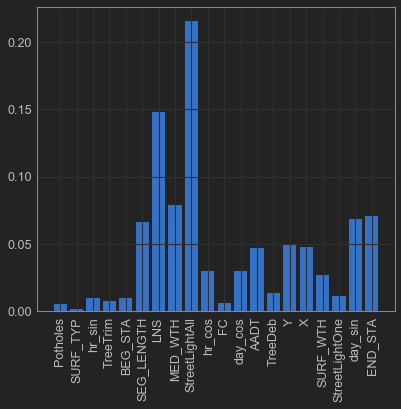

In [5]:
#ignore these two lines (jupyter notebook theme settings)
#from jupyterthemes import jtplot
#jtplot.style(theme='monokai')

#export the feature importance calculate
#the OHE_decoder function was coded such that it works for multiple models. Latitude and longitude were required in the AADT model, so "None" is used here to fill the place for "X" and "Y"
feature_importance = utility_functions.OHE_decoder(None, None, categorical,floating+integer,ohe,rf.feature_importances_,aggregate='average',visualize=True,output=True)

In [6]:
feature_importance.sort_values(by='Values',ascending=False, inplace=True)
feature_importance.to_csv('feature_importance.csv',index_label=False)

Just trying other visualization method... (Bokeh)

In [11]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

output_notebook()

Loading BokehJS ...

In [18]:
p = figure(x_range=feature_importance['Variable'], plot_height=300, title="Feature Importance",
           toolbar_location=None, tools="")

p.background_fill_color = 'beige'
p.vbar(x='Variable', top='Values', width=0.9, source=feature_importance, fill_color='lightblue')

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.major_label_orientation = 1.0

show(p)